In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from kan import KAN, create_dataset

# Configuración del dispositivo para PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# Descargar datos históricos
ticker = 'AAPL'
data = yf.download(ticker, period='24y', interval='1d')

# Calcular los retornos porcentuales para 'Open', 'Close', 'High', y 'Low'
data['Return_Open'] = data['Open'].pct_change()
data['Return_Close'] = data['Close'].pct_change()
data['Return_High'] = data['High'].pct_change()
data['Return_Low'] = data['Low'].pct_change()
data = data.dropna()

# Preparar los datos de entrada y salida
features = ['Return_Open', 'Return_Close', 'Return_High', 'Return_Low']
scalers = {feature: MinMaxScaler(feature_range=(0, 1)) for feature in features}

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Escalamiento de los datos
for feature in features:
    data.loc[:,feature] = scalers[feature].fit_transform(data[[feature]])

# Preparar datos para el modelo KAN
X_Kan = np.array([data[features].values[i-2:i].flatten() for i in range(2, len(data))])
y_Kan = data[features].iloc[2:].values

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_Kan, y_Kan, test_size=0.2, random_state=42)
test_dates = data.index[2 + len(X_train):2 + len(X_train) + len(X_test)]

# Convertir datos a tensores de PyTorch
dataset = {
    'train_input': torch.tensor(X_train, dtype=torch.float32),
    'test_input': torch.tensor(X_test, dtype=torch.float32),
    'device': device
}

train loss: 2.18e-02 | test loss: 2.50e-02 | reg: 1.08e+02 : 100%|██| 50/50 [12:16<00:00, 14.74s/it]


Return_Open - Test Metrics - R^2: 0.600, MAE: 0.010, MSE: 0.000


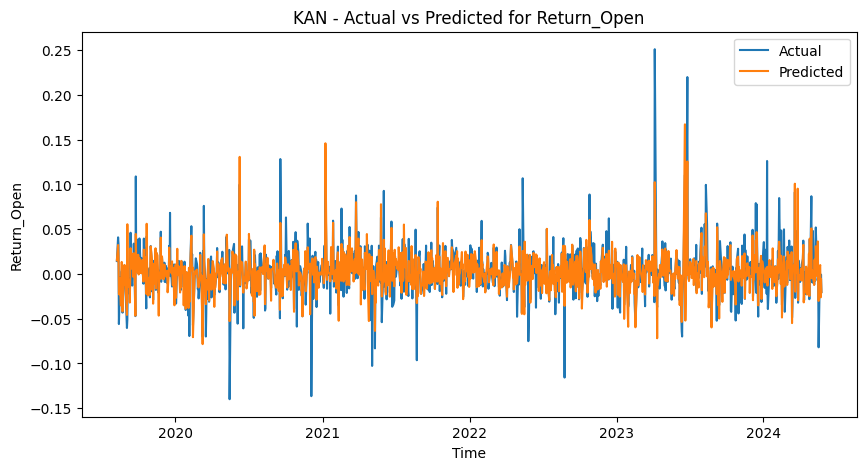

train loss: nan | test loss: nan | reg: nan :  20%|███▍             | 10/50 [02:37<10:31, 15.78s/it]


RuntimeError: false INTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\native\\BatchLinearAlgebra.cpp":1538, please report a bug to PyTorch. torch.linalg.lstsq: (Batch element 0): Argument 6 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

In [4]:
# Entrenar y evaluar un modelo KAN para cada característica
results = {}
for i, feature in enumerate(features):
    dataset['train_label'] = torch.tensor(y_train[:, i], dtype=torch.float32).view(-1, 1)
    dataset['test_label'] = torch.tensor(y_test[:, i], dtype=torch.float32).view(-1, 1)

    model = KAN(width=[8, 16, 12, 8, 4, 1], grid=5, k=3).to(device)
    model.train(dataset, opt="LBFGS", steps=50)

    # Obtener predicciones y aplicar transformación inversa
    y_pred_test = model(dataset['test_input']).detach().cpu().numpy()
    y_pred_test = scalers[feature].inverse_transform(y_pred_test)

    y_true = scalers[feature].inverse_transform(dataset['test_label'].cpu().numpy())

    # Calcular métricas
    r2 = r2_score(y_true, y_pred_test)
    mae = mean_absolute_error(y_true, y_pred_test)
    mse = mean_squared_error(y_true, y_pred_test)
    results[feature] = {'test_r2': r2, 'test_mae': mae, 'test_mse': mse}
    
    print(f"{feature} - Test Metrics - R^2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, y_true, label='Actual')
    plt.plot(test_dates, y_pred_test, label='Predicted')
    plt.title(f'KAN - Actual vs Predicted for {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

In [ ]:
print(results)

{'Return_Open': {'test_r2': 0.8740016429228114, 'test_mae': 0.011406791, 'test_mse': 0.00026034092}, 'Return_Close': {'test_r2': -0.1751371877222201, 'test_mae': 0.03632676, 'test_mse': 0.0023822065}, 'Return_High': {'test_r2': 0.22730309325490994, 'test_mae': 0.02452067, 'test_mse': 0.0011574817}, 'Return_Low': {'test_r2': -0.10975112635880979, 'test_mae': 0.031376, 'test_mse': 0.0016408762}}


data = yf.download(ticker, period='24y', interval='1wk')

model = KAN(width=[8, 16, 12, 8, 4, 1], grid=5, k=3).to(device)

{'Return_Open': {'test_r2': 0.8740016429228114, 'test_mae': 0.011406791, 'test_mse': 0.00026034092},

 'Return_Close': {'test_r2': -0.1751371877222201, 'test_mae': 0.03632676, 'test_mse': 0.0023822065},
 
  'Return_High': {'test_r2': 0.22730309325490994, 'test_mae': 0.02452067, 'test_mse': 0.0011574817},
  
   'Return_Low': {'test_r2': -0.10975112635880979, 'test_mae': 0.031376, 'test_mse': 0.0016408762}}

data = yf.download(ticker, period='24y', interval='1d')

model = KAN(width=[8, 16, 12, 8, 4, 1], grid=5, k=3).to(device)

